In [19]:
from typing import ClassVar, List, Dict, Optional
from pydantic import BaseModel, Field

from langchain_gigachat.chat_models import GigaChat
from datetime import datetime

from typing import  List, Dict
from pydantic import BaseModel
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END

import uuid
import json
import time

In [20]:
import phoenix as px
# session = px.launch_app(use_temp_dir=False) # Fo colab
session = px.launch_app()

Existing running Phoenix instance detected! Shutting it down and starting a new instance...


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [21]:
from phoenix.otel import register
from openinference.instrumentation.langchain import LangChainInstrumentor

tracer_provider = register(
  project_name="Agentic reasoning", # Default is 'default'
  endpoint="http://localhost:4317",
)

LangChainInstrumentor().instrument(tracer_provider=tracer_provider)

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: Agentic reasoning
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [22]:
gigachat_api_key = "NTQ3YmYxZTItZDg5ZS00YjNkLWJjNjMtNTJlZWY0OTM1MWFlOmEwYTg2YjlhLTExNmEtNGI5MS04MGY2LTlmYTFiYzllNTM4Mw=="


MAIN_TEMPLATE: ClassVar[str] = f"""Ты - AI архитектор предприятия. Сегодняшняя дата - {datetime.now().strftime('%Y-%m-%d')}
Твоя задача - анализировать данные из различных источников и выявлять взаимосвязи между системами."""

# Инициализация моделей
chat = GigaChat(
    credentials=gigachat_api_key,
    model="GigaChat-2-Max",
    verify_ssl_certs=False
)



In [24]:

class SystemRelation(BaseModel):
    system_a: str
    system_b: str
    relation_type: str
    description: str
    sources: List[str]

class SystemRelationsState(BaseModel):
    confluence_data: Dict = {}
    meta_data: Dict = {}
    telegram_data: List[str] = []
    aggregated_relations: List[SystemRelation] = []
    data_requests: List[str] = []
    search_results: Dict = {}

class Route(BaseModel):
    """Определяет следующий источник данных для обработки в workflow"""
    step: str = Field(..., description="Source to process next: confluence, meta, telegram, aggregate")

gigachat_router = chat.with_structured_output(Route)

In [33]:
#print(dir(chat))

In [25]:
gigachat_router = chat.with_structured_output(Route)

# Функции для работы с источниками данных

def get_confluence_data(state: SystemRelationsState):
    """Пример получения данных из Confluence"""
    print("Получение данных из Confluence...")
    # Здесь должен быть реальный код интеграции с Confluence API
    state.confluence_data = {
        "Архитектурные решения": {
            "Система A": "Интегрируется с Системой B через REST API",
            "Система C": "Использует базу данных Системы D"
        }
    }
    return {"confluence_data": state.confluence_data}


def get_meta_data(state: SystemRelationsState):
    """Пример получения данных из Meta системы"""
    print("Получение данных из Meta...")
    # Здесь должен быть реальный код интеграции с Meta API
    state.meta_data = {
        "systems": [
            {"name": "Система A", "dependencies": ["Система B"]},
            {"name": "Система B", "dependencies": ["Система C"]}
        ]
    }
    return {"meta_data": state.meta_data}


def get_telegram_data(state: SystemRelationsState):
    """Пример получения данных из Telegram"""
    print("Получение данных из Telegram...")
    # Здесь должен быть реальный код интеграции с Telegram API
    state.telegram_data = [
        "В чате DevOps: Система E временно использует ресурсы Системы F до миграции"
    ]
    return {"telegram_data": state.telegram_data}


In [7]:
# from langchain.chains import ChatChain
# 
# def analyze_relations_ru(state: SystemRelationsState):
#     """Анализ и агрегация данных."""
#     
#     # Формирование шаблона для запроса
#     prompt = ChatPromptTemplate.from_template("""
#     Анализируй входящие данные и агрегируй их. У нас есть три источника данных:
#     1. Confluence Data: {confluence}
#     2. Meta Data: {meta}
#     3. Telegram Data: {telegram}
#     
#     Обработай данные, выяви важные связи, и выведи отчет о взаимосвязях и возможных паттернах.
#     """)
#     
#     # Создание цепочки для обработки данных
#     chain = prompt | ChatChain() | StrOutputParser()
#     
#     # Входные данные в формате JSON
#     inputs = {
#         "confluence": json.dumps(state.confluence_data, ensure_ascii=False),
#         "meta": json.dumps(state.meta_data, ensure_ascii=False),
#         "telegram": "\n".join(state.telegram_data)
#     }
#     
#     # Выполняем анализ данных
#     analysis_result = chain.invoke(inputs)
#     
#     # Сохраняем результат анализа в состояние
#     state.analysis = analysis_result
#     
#     # Возвращаем обновленное состояние с результатами анализа
#     return state


In [26]:
from langchain.chains import LLMChain
def analyze_relations_1(state: SystemRelationsState):
    """Анализ и агрегация данных."""
    
    # Формирование шаблона для запроса
    prompt = ChatPromptTemplate.from_template("""
    Анализируй входящие данные и агрегируй их. У нас есть три источника данных:
    1. Confluence Data: {confluence}
    2. Meta Data: {meta}
    3. Telegram Data: {telegram}
    
    Обработай данные, выяви важные связи, и выведи отчет о взаимосвязях и возможных паттернах. Если между системами нет необходимо акцентировать внимание на том, что между системами связи не выявлено
    """)
    
    # Инициализация модели (используется OpenAI, но можно заменить на любую другую модель)
      # Можете заменить на нужную модель
    
    # Создание цепочки для обработки данных
    chain = LLMChain(prompt=prompt, llm=chat, output_parser=StrOutputParser())
    
    # Входные данные в формате JSON
    inputs = {
        "confluence": json.dumps(state.confluence_data, ensure_ascii=False),
        "meta": json.dumps(state.meta_data, ensure_ascii=False),
        "telegram": "\n".join(state.telegram_data)
    }
    
    # Выполняем анализ данных
    analysis_result = chain.run(inputs)
    
    # Сохраняем результат анализа в состояние
    state.analysis = analysis_result
    
    # Возвращаем обновленное состояние с результатами анализа
    return state

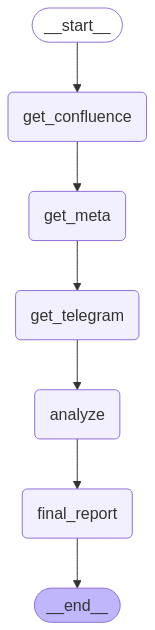

In [27]:


class SystemRelation(BaseModel):
    system_a: str
    system_b: str
    relation_type: str
    description: str
    sources: List[str]

class SystemRelationsState(BaseModel):
    confluence_data: Dict = {}
    meta_data: Dict = {}
    telegram_data: List[str] = []
    aggregated_relations: List[SystemRelation] = []
    data_requests: List[str] = []
    search_results: Dict = {}
    analysis: str = ""  # Добавлено новое поле
    report: str = ""    # Добавлено поле для отчета


# Функции обработки данных

# Исправленная функция analyze_relations
def analyze_relations(state: SystemRelationsState):
    """Анализ и агрегация данных"""
    prompt = ChatPromptTemplate.from_template("...")  # Ваш шаблон промпта
    
    chain = prompt | chat | StrOutputParser()
    
    # Сохраняем результат анализа прямо в состояние
    state.analysis = chain.invoke({
        "confluence": json.dumps(state.confluence_data, ensure_ascii=False),
        "meta": json.dumps(state.meta_data, ensure_ascii=False),
        "telegram": "\n".join(state.telegram_data)
    })
    
    return state  # Возвращаем обновленное состояние



# Исправленная функция format_final_report
def format_final_report(state: SystemRelationsState):
    """Формирование итогового отчета"""
    prompt = ChatPromptTemplate.from_template("сформировать агрегированные данные из источников в формате json, НЕ ПРИДУМЫВАЙ когда собираешь источники данных бери данные только из функций confluence meta telegram")  # Ваш шаблон промпта
    
    chain = prompt | chat | StrOutputParser()
    state.report = chain.invoke({"analysis": state.analysis})
    return state  # Возвращаем обновленное состояние
# Маршрутизация
def router(state: SystemRelationsState):
    """Определение следующего шага обработки"""
    if not state.confluence_data:
        return {"decision": "confluence"}
    if not state.meta_data:
        return {"decision": "meta"}
    if not state.telegram_data:
        return {"decision": "telegram"}
    return {"decision": "aggregate"}

# Построение графа
workflow = StateGraph(SystemRelationsState)

workflow.add_node("get_confluence", get_confluence_data)
workflow.add_node("get_meta", get_meta_data)
workflow.add_node("get_telegram", get_telegram_data)
workflow.add_node("analyze", analyze_relations_1)
workflow.add_node("final_report", format_final_report)

workflow.add_edge("get_confluence", "get_meta")
workflow.add_edge("get_meta", "get_telegram")
workflow.add_edge("get_telegram", "analyze")
workflow.add_edge("analyze", "final_report")
workflow.add_edge("final_report", END)

workflow.set_entry_point("get_confluence")
app = workflow.compile()

app

In [28]:
# Запуск
async def run_agent():
    inputs = {"user_query": "Построй карту взаимосвязей между системами"}
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    
    async for event in app.astream_events(inputs, version="v2"):
        event_type = event.get('event', None)
        node = event.get('name', '')
        
        if event_type == 'on_chain_start':
            print(f"\n[{node.upper()}]")
        elif event_type == 'on_chain_end':
            print(f"[/{node.upper()}]")
        elif event_type == 'on_chat_model_stream':
            print(event['data']['chunk'].content, end='')

start = time.time()
await run_agent()
print(f"\nTotal time: {time.time() - start:.2f}s")

Transient error StatusCode.UNAVAILABLE encountered while exporting traces to localhost:4317, retrying in 1s.



[LANGGRAPH]

[__START__]

[_WRITE]
[/_WRITE]

[_WRITE]
[/_WRITE]
[/__START__]

[GET_CONFLUENCE]
Получение данных из Confluence...

[_WRITE]
[/_WRITE]
[/GET_CONFLUENCE]

[GET_META]
Получение данных из Meta...

[_WRITE]
[/_WRITE]
[/GET_META]

[GET_TELEGRAM]
Получение данных из Telegram...

[_WRITE]
[/_WRITE]
[/GET_TELEGRAM]

[ANALYZE]

[LLMCHAIN]
Для анализа предоставленных данных начнем с рассмотрения каждого источника отдельно и выявления ключевых связей между системами.

### Источник №1 — **Confluence Data**
Здесь представлены архитектурные решения двух систем:
- **Система A** интегрируется с **Системой B** через REST API.
- **Система C** использует базу данных от **Системы D**.

Это позволяет нам выявить две прямые зависимости:
1. **A → B**: система А зависит от системы B (через REST API).
2. **C → D**: система C зависит от базы данных системы D.

### Источник №2 — **Meta Data**
Этот источник содержит метаданные о зависимостях между несколькими системами:
- **Система A** имеет завис

ValueError: "SystemRelationsState" object has no field "analysis"